# Pokemon Sprite Generation: Data Analysis

Data pipeline analysis for ARGB artwork-to-sprite translation model.

In [7]:
import os
import sys
import json
from pathlib import Path

# Add src to path
current_dir = Path.cwd()
src_path = current_dir.parent / "src"
sys.path.insert(0, str(src_path))

from data.loaders import find_matching_pairs
from data.augmentation import AdvancedAugmentationPipeline
from core.logging_config import initialize_project_logging, get_logger

# Setup logging
initialize_project_logging(
    project_name="pokemon_sprites",
    log_level="WARNING",
    model_name="data_analysis",
    experiment_id="notebook"
)
logger = get_logger("data_analysis")

# Load configuration
config_path = src_path / "config" / "model_configs.json"
with open(config_path, 'r') as f:
    project_config = json.load(f)

AUGMENTATION_CONFIG_TYPE = "moderate"
augmentation_config = project_config["augmentation_configs"][AUGMENTATION_CONFIG_TYPE]

In [8]:
# Dataset analysis
pokemon_data_path = Path("../data/pokemon_complete")
sprites_dir = pokemon_data_path / "sprites"
artwork_dir = pokemon_data_path / "artwork"

valid_pairs = find_matching_pairs(sprites_dir, artwork_dir)

print(f"Found {len(valid_pairs)} valid pairs")
if len(valid_pairs) == 0:
    print("ERROR: No valid pairs found")

Found 898 valid pairs


In [9]:
# Initialize augmentation pipeline
augmentation_pipeline = AdvancedAugmentationPipeline(config_dict=augmentation_config)

In [10]:
# Dataset verification
if len(valid_pairs) > 0:
    sample_artwork, sample_sprite = valid_pairs[0]
    artwork_exists = sample_artwork.exists()
    sprite_exists = sample_sprite.exists()
    
    print(f"Total pairs: {len(valid_pairs)}")
    print(f"Sample verification: {'PASS' if artwork_exists and sprite_exists else 'FAIL'}")
else:
    print("Dataset verification: FAIL - no pairs found")

Total pairs: 898
Sample verification: PASS


Architecture: RGBA→RGBA → P→RGBA
Model: 4 input channels → 4 output channels
Discriminator: 8 channels (4+4)

EXHAUSTIVE AUGMENTATION DEMONSTRATION

1. HORIZONTAL FLIP - Paired Transformation:
   → Input: Flipped if random < p
   → Target: SAME flip applied to maintain correspondence


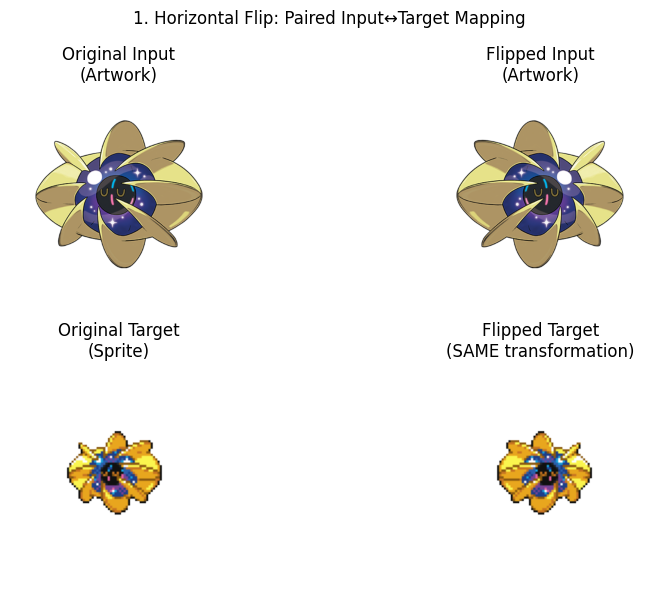


2. COLOR JITTER - Paired Input/Target Mapping:
   → Input: Gets color jitter (brightness, contrast, saturation, hue)
   → Target: Gets SAME color jitter to maintain correspondence
   → Updated from independent to paired for better pixel art generation


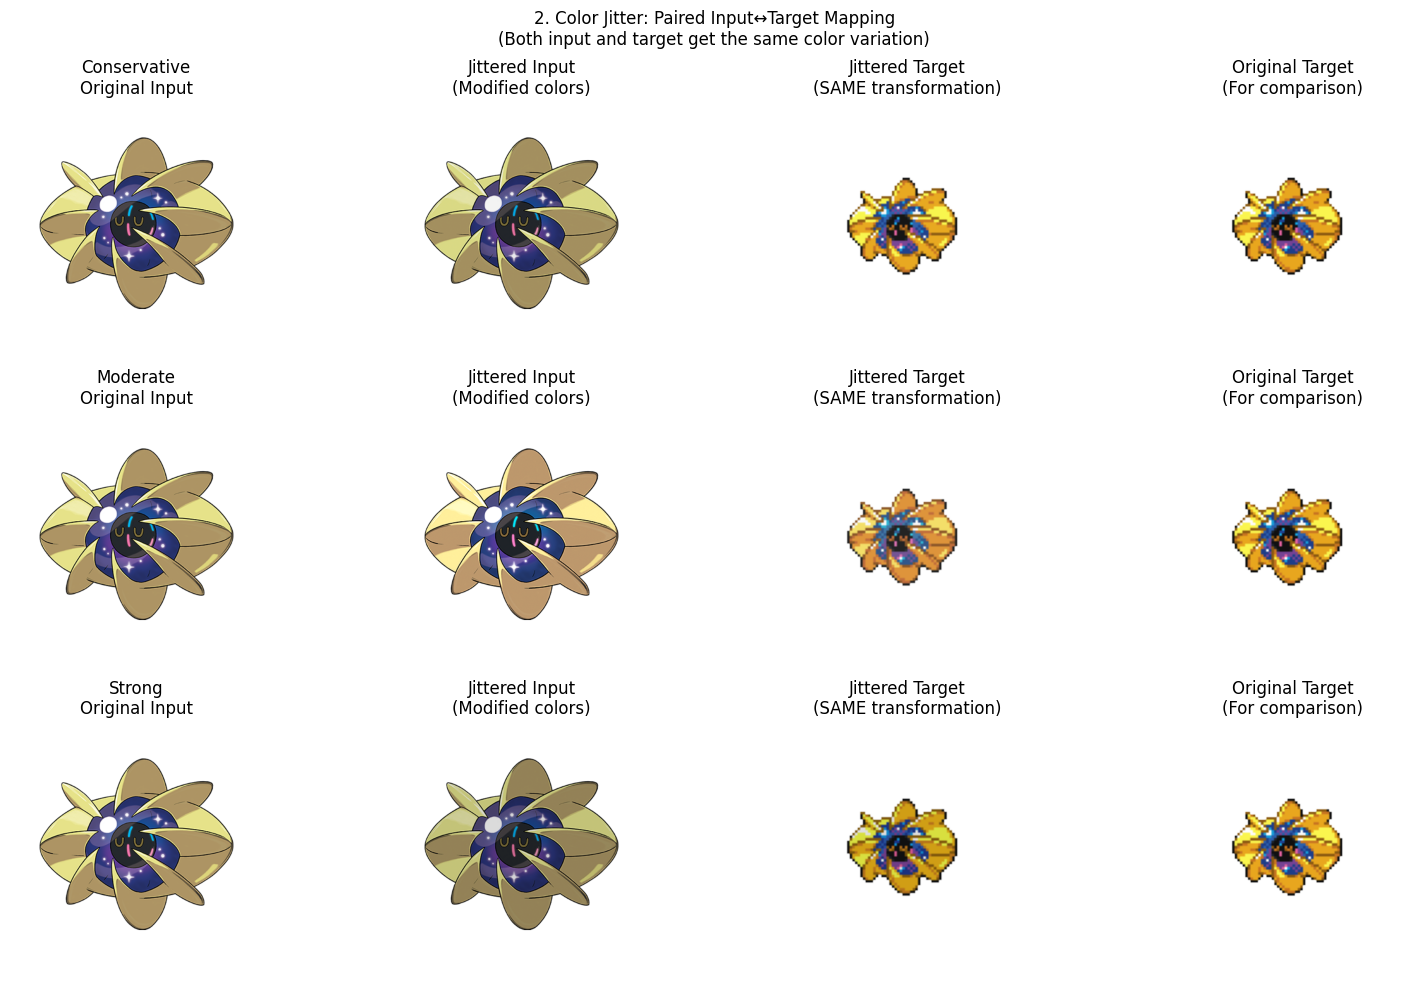


3. ROTATION - Paired Transformation:
   → Input: Rotated by random angle ±degrees
   → Target: SAME rotation applied to maintain spatial correspondence


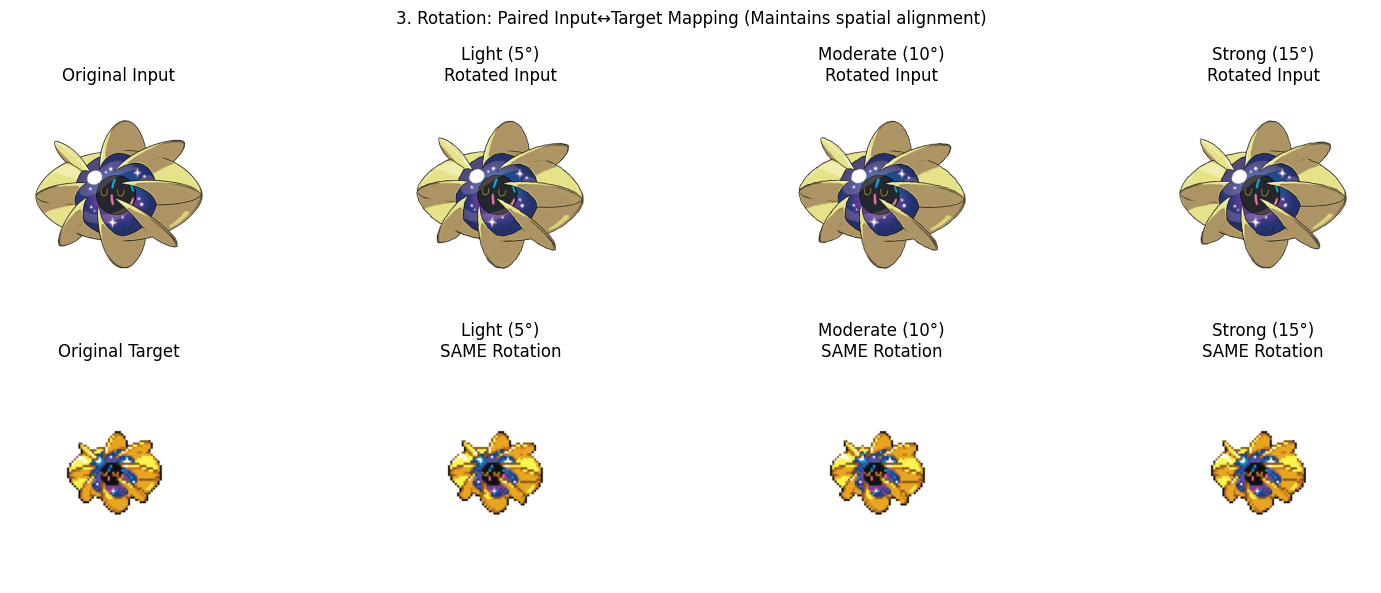


4. RANDOM AFFINE - Paired Transformation:
   → Input: Random scaling and translation
   → Target: SAME transformation to maintain spatial correspondence
   → Teaches model geometric robustness while preserving alignment


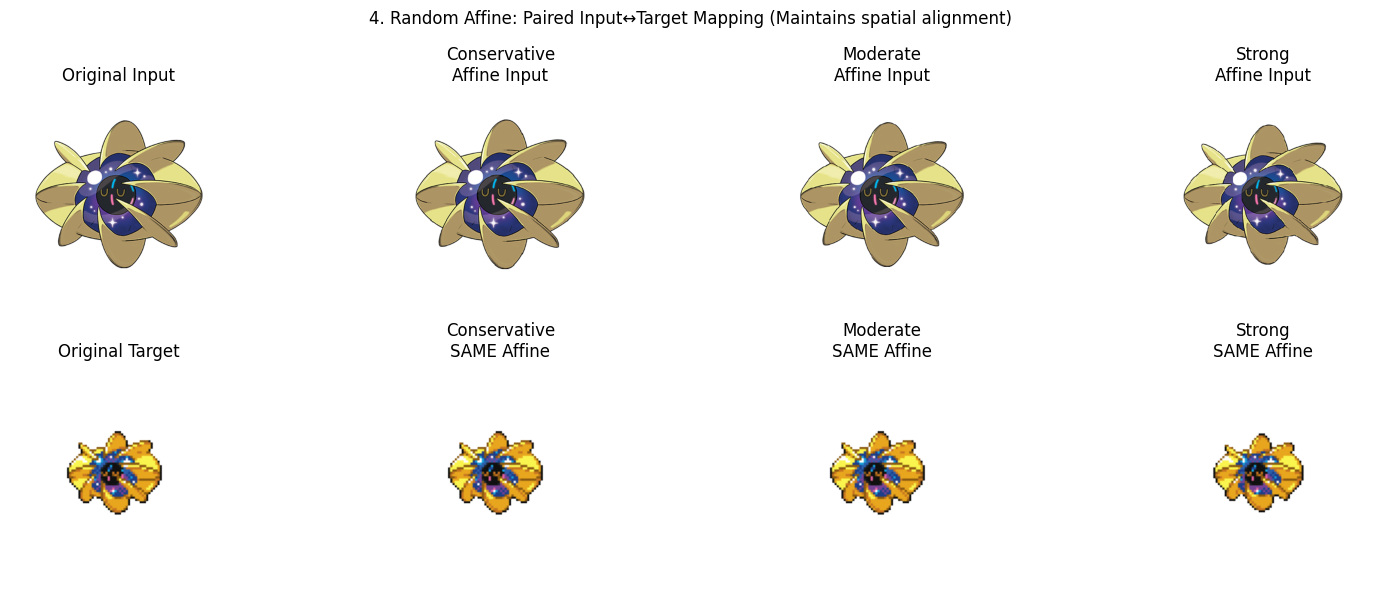


5. CUTOUT - Paired Transformation:
   → Input: Random rectangular regions set to zero
   → Target: SAME regions cut out to maintain correspondence
   → Updated to paired implementation for better training


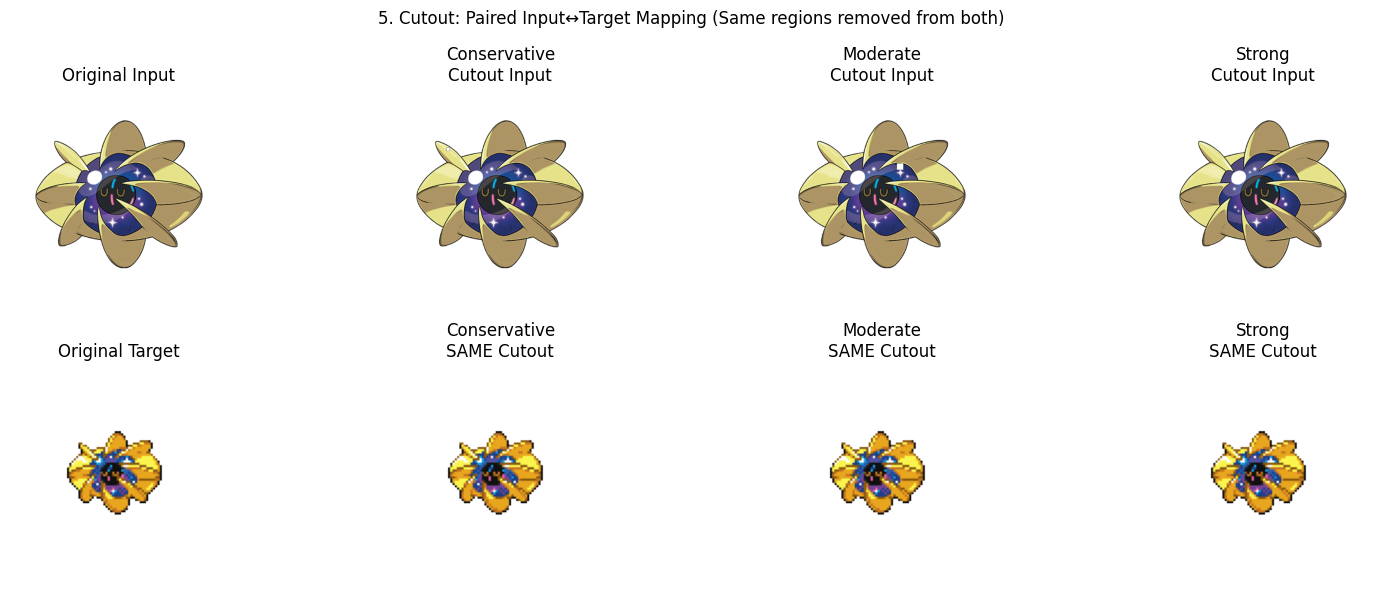


6. REMOVED AUGMENTATIONS:
   → Noise Augmentation: REMOVED (counterproductive for pixel art)
   → Mixup Augmentation: REMOVED (questionable for pixel art generation)
   → Blur: REMOVED (not suitable for crisp pixel art)
   → These were removed based on user feedback about hurting model performance

7. AUGMENTATION PHILOSOPHY CHANGE:
   → Changed from independent input/target transformations
   → To paired transformations that maintain correspondence
   → Focus on geometric and color consistency between input and target
   → Removed transformations that could degrade pixel art quality

8. MIXUP - Previously Available (Now Removed):
   → Was available in production config with alpha=0.2, p=0.1
   → Removed due to being questionable for pixel art generation
   → Linear combination could blur crisp pixel art boundaries


/tmp/ipykernel_12015/4236206804.py:263: DeprecationWarning: 'mode' parameter is deprecated and will be removed in Pillow 13 (2026-10-15)
  mixed_artwork = Image.fromarray(mixed_art, mode='RGBA')
/tmp/ipykernel_12015/4236206804.py:264: DeprecationWarning: 'mode' parameter is deprecated and will be removed in Pillow 13 (2026-10-15)
  mixed_sprite = Image.fromarray(mixed_spr, mode='RGBA')


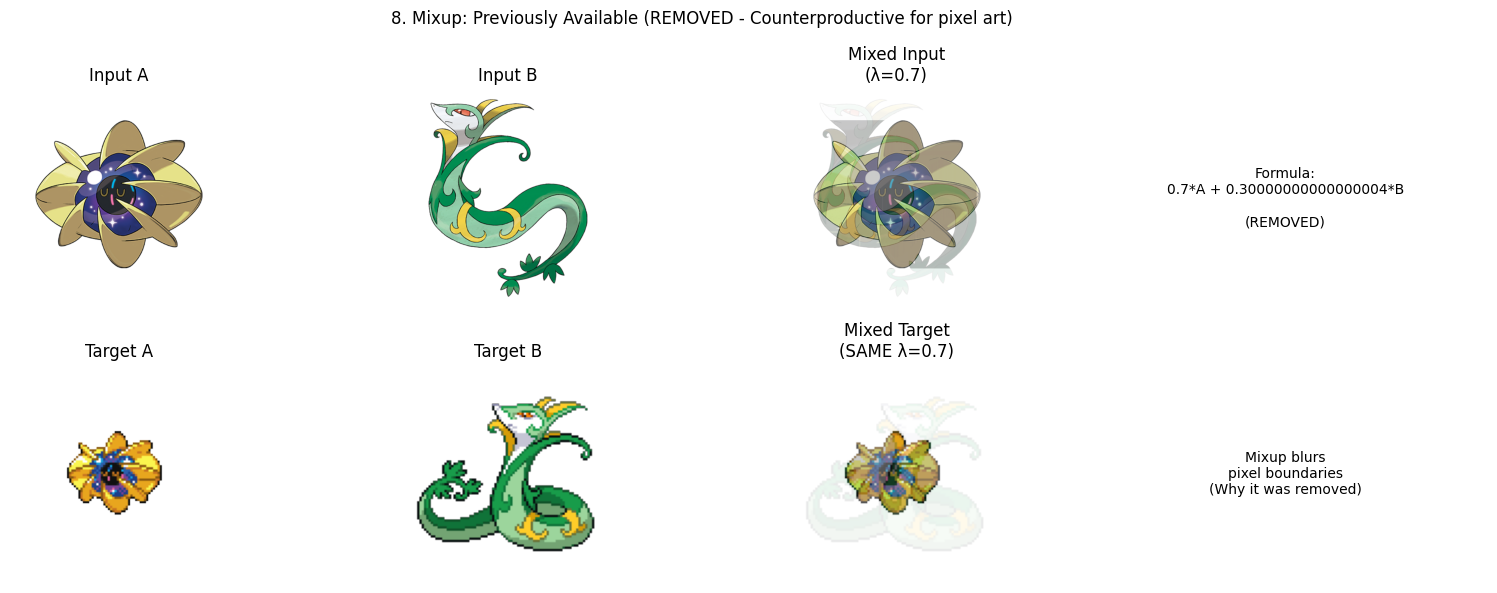


SUMMARY OF CURRENT AUGMENTATION TECHNIQUES:
1. Horizontal Flip: PAIRED (same transformation)
2. Color Jitter: PAIRED (same color changes for both)
3. Rotation: PAIRED (same transformation)
4. Random Affine: PAIRED (same geometric transformation)
5. Cutout: PAIRED (same regions removed from both)
6. Noise: REMOVED (counterproductive)
7. Blur: REMOVED (not suitable for pixel art)
8. Mixup: REMOVED (blurs pixel boundaries)
PHILOSOPHY: All augmentations now maintain input↔target correspondence


In [11]:
# Comprehensive Augmentation Analysis
import matplotlib.pyplot as plt
from PIL import Image
import numpy as np

if valid_pairs:
    # Load sample images
    sample_artwork, sample_sprite = valid_pairs[0]
    artwork_raw = Image.open(sample_artwork)
    sprite_raw = Image.open(sample_sprite)
    
    # Convert to RGBA (4 channels)
    artwork_rgba = artwork_raw.convert('RGBA') if artwork_raw.mode != 'RGBA' else artwork_raw
    sprite_rgba = sprite_raw.convert('RGBA') if sprite_raw.mode != 'RGBA' else sprite_raw
    
    print(f"Architecture: {artwork_raw.mode}→RGBA → {sprite_raw.mode}→RGBA")
    print(f"Model: 4 input channels → 4 output channels")
    print(f"Discriminator: 8 channels (4+4)")
    
    # === EXHAUSTIVE AUGMENTATION DEMONSTRATION ===
    print("\n" + "="*60)
    print("EXHAUSTIVE AUGMENTATION DEMONSTRATION")
    print("="*60)
    
    # 1. Horizontal Flip (Paired - Same transformation on both)
    print("\n1. HORIZONTAL FLIP - Paired Transformation:")
    print("   → Input: Flipped if random < p")
    print("   → Target: SAME flip applied to maintain correspondence")
    
    from data.augmentation import PairedRandomHorizontalFlip
    
    flip_transform = PairedRandomHorizontalFlip(p=1.0)  # Force flip for demo
    flipped_artwork, flipped_sprite = flip_transform(artwork_rgba, sprite_rgba)
    
    fig, axes = plt.subplots(2, 2, figsize=(10, 6))
    axes[0,0].imshow(artwork_rgba)
    axes[0,0].set_title('Original Input\n(Artwork)')
    axes[0,0].axis('off')
    
    axes[0,1].imshow(flipped_artwork)
    axes[0,1].set_title('Flipped Input\n(Artwork)')
    axes[0,1].axis('off')
    
    axes[1,0].imshow(sprite_rgba)
    axes[1,0].set_title('Original Target\n(Sprite)')
    axes[1,0].axis('off')
    
    axes[1,1].imshow(flipped_sprite)
    axes[1,1].set_title('Flipped Target\n(SAME transformation)')
    axes[1,1].axis('off')
    
    plt.suptitle('1. Horizontal Flip: Paired Input↔Target Mapping')
    plt.tight_layout()
    plt.show()
    
    # 2. Color Jitter (Paired - Same transformations)
    print("\n2. COLOR JITTER - Paired Input/Target Mapping:")
    print("   → Input: Gets color jitter (brightness, contrast, saturation, hue)")
    print("   → Target: Gets SAME color jitter to maintain correspondence")
    print("   → Updated from independent to paired for better pixel art generation")
    
    from data.augmentation import PairedColorJitter
    
    # Test different intensity levels from configs
    jitter_configs = [
        ("Conservative", {"brightness": 0.05, "contrast": 0.03, "saturation": 0.03, "hue": 0.015}),
        ("Moderate", {"brightness": 0.12, "contrast": 0.10, "saturation": 0.12, "hue": 0.04}),
        ("Strong", {"brightness": 0.15, "contrast": 0.12, "saturation": 0.15, "hue": 0.06})
    ]
    
    fig, axes = plt.subplots(3, 4, figsize=(16, 10))
    
    for i, (name, config) in enumerate(jitter_configs):
        jitter = PairedColorJitter(**config)
        jittered_artwork, jittered_sprite = jitter(artwork_rgba, sprite_rgba)
        
        # Original pair
        axes[i,0].imshow(artwork_rgba)
        axes[i,0].set_title(f'{name}\nOriginal Input')
        axes[i,0].axis('off')
        
        # Jittered input
        axes[i,1].imshow(jittered_artwork)
        axes[i,1].set_title(f'Jittered Input\n(Modified colors)')
        axes[i,1].axis('off')
        
        # Jittered target (SAME transformation)
        axes[i,2].imshow(jittered_sprite)
        axes[i,2].set_title(f'Jittered Target\n(SAME transformation)')
        axes[i,2].axis('off')
        
        # Original target for comparison
        axes[i,3].imshow(sprite_rgba)
        axes[i,3].set_title(f'Original Target\n(For comparison)')
        axes[i,3].axis('off')
    
    plt.suptitle('2. Color Jitter: Paired Input↔Target Mapping\n(Both input and target get the same color variation)')
    plt.tight_layout()
    plt.show()
    
    # 3. Rotation (Paired - Same transformation)
    print("\n3. ROTATION - Paired Transformation:")
    print("   → Input: Rotated by random angle ±degrees")
    print("   → Target: SAME rotation applied to maintain spatial correspondence")
    
    from data.augmentation import PairedRandomRotation
    
    rotation_configs = [
        ("Light", 5),
        ("Moderate", 10), 
        ("Strong", 15)
    ]
    
    fig, axes = plt.subplots(2, 4, figsize=(16, 6))
    
    # Original
    axes[0,0].imshow(artwork_rgba)
    axes[0,0].set_title('Original Input')
    axes[0,0].axis('off')
    axes[1,0].imshow(sprite_rgba)
    axes[1,0].set_title('Original Target')
    axes[1,0].axis('off')
    
    for i, (name, degrees) in enumerate(rotation_configs):
        rotation = PairedRandomRotation(degrees=degrees)
        rotated_artwork, rotated_sprite = rotation(artwork_rgba, sprite_rgba)
        
        axes[0,i+1].imshow(rotated_artwork)
        axes[0,i+1].set_title(f'{name} ({degrees}°)\nRotated Input')
        axes[0,i+1].axis('off')
        
        axes[1,i+1].imshow(rotated_sprite)
        axes[1,i+1].set_title(f'{name} ({degrees}°)\nSAME Rotation')
        axes[1,i+1].axis('off')
    
    plt.suptitle('3. Rotation: Paired Input↔Target Mapping (Maintains spatial alignment)')
    plt.tight_layout()
    plt.show()
    
    # 4. Random Affine (Paired transformation)
    print("\n4. RANDOM AFFINE - Paired Transformation:")
    print("   → Input: Random scaling and translation")
    print("   → Target: SAME transformation to maintain spatial correspondence")
    print("   → Teaches model geometric robustness while preserving alignment")
    
    from data.augmentation import PairedRandomAffine
    
    affine_configs = [
        ("Conservative", {"translate": [0.02, 0.02], "scale": [0.98, 1.02], "p": 1.0}),
        ("Moderate", {"translate": [0.05, 0.05], "scale": [0.95, 1.05], "p": 1.0}),
        ("Strong", {"translate": [0.08, 0.08], "scale": [0.9, 1.1], "p": 1.0})
    ]
    
    fig, axes = plt.subplots(2, 4, figsize=(16, 6))
    
    # Original
    axes[0,0].imshow(artwork_rgba)
    axes[0,0].set_title('Original Input')
    axes[0,0].axis('off')
    axes[1,0].imshow(sprite_rgba)
    axes[1,0].set_title('Original Target')
    axes[1,0].axis('off')
    
    for i, (name, config) in enumerate(affine_configs):
        affine = PairedRandomAffine(**config)
        affine_artwork, affine_sprite = affine(artwork_rgba, sprite_rgba)
        
        axes[0,i+1].imshow(affine_artwork)
        axes[0,i+1].set_title(f'{name}\nAffine Input')
        axes[0,i+1].axis('off')
        
        axes[1,i+1].imshow(affine_sprite)
        axes[1,i+1].set_title(f'{name}\nSAME Affine')
        axes[1,i+1].axis('off')
    
    plt.suptitle('4. Random Affine: Paired Input↔Target Mapping (Maintains spatial alignment)')
    plt.tight_layout()
    plt.show()
    
    # 5. Cutout (Paired transformation)
    print("\n5. CUTOUT - Paired Transformation:")
    print("   → Input: Random rectangular regions set to zero")
    print("   → Target: SAME regions cut out to maintain correspondence")
    print("   → Updated to paired implementation for better training")
    
    from data.augmentation import PairedCutout
    
    cutout_configs = [
        ("Conservative", {"size_ratio": 64, "p": 1.0}),
        ("Moderate", {"size_ratio": 32, "p": 1.0}), 
        ("Strong", {"size_ratio": 24, "p": 1.0})
    ]
    
    fig, axes = plt.subplots(2, 4, figsize=(16, 6))
    
    # Original
    axes[0,0].imshow(artwork_rgba)
    axes[0,0].set_title('Original Input')
    axes[0,0].axis('off')
    axes[1,0].imshow(sprite_rgba)
    axes[1,0].set_title('Original Target')
    axes[1,0].axis('off')
    
    for i, (name, config) in enumerate(cutout_configs):
        cutout = PairedCutout(**config)
        cutout_artwork, cutout_sprite = cutout(artwork_rgba, sprite_rgba)
        
        axes[0,i+1].imshow(cutout_artwork)
        axes[0,i+1].set_title(f'{name}\nCutout Input')
        axes[0,i+1].axis('off')
        
        axes[1,i+1].imshow(cutout_sprite)
        axes[1,i+1].set_title(f'{name}\nSAME Cutout')
        axes[1,i+1].axis('off')
    
    plt.suptitle('5. Cutout: Paired Input↔Target Mapping (Same regions removed from both)')
    plt.tight_layout()
    plt.show()
    
    # 6. Removed Augmentations (No longer available)
    print("\n6. REMOVED AUGMENTATIONS:")
    print("   → Noise Augmentation: REMOVED (counterproductive for pixel art)")
    print("   → Mixup Augmentation: REMOVED (questionable for pixel art generation)")
    print("   → Blur: REMOVED (not suitable for crisp pixel art)")
    print("   → These were removed based on user feedback about hurting model performance")
    
    # 7. Legacy note about removed features
    print("\n7. AUGMENTATION PHILOSOPHY CHANGE:")
    print("   → Changed from independent input/target transformations")
    print("   → To paired transformations that maintain correspondence")
    print("   → Focus on geometric and color consistency between input and target")
    print("   → Removed transformations that could degrade pixel art quality")
    
    try:
        # Note about removed mixup (keeping the demo code but noting it's removed)
        print("\n8. MIXUP - Previously Available (Now Removed):")
        print("   → Was available in production config with alpha=0.2, p=0.1")
        print("   → Removed due to being questionable for pixel art generation")
        print("   → Linear combination could blur crisp pixel art boundaries")
        
        # Get second sample for demonstration (if available)
        if len(valid_pairs) > 1:
            sample2_artwork, sample2_sprite = valid_pairs[1]
            artwork2_rgba = Image.open(sample2_artwork).convert('RGBA')
            sprite2_rgba = Image.open(sample2_sprite).convert('RGBA')
            
            # Resize to match
            artwork2_rgba = artwork2_rgba.resize(artwork_rgba.size)
            sprite2_rgba = sprite2_rgba.resize(sprite_rgba.size)
            
            # Simulate what mixup would have done (for educational purposes)
            lam = 0.7  # Example lambda
            
            # Manual mixup simulation
            art1_array = np.array(artwork_rgba).astype(np.float32)
            art2_array = np.array(artwork2_rgba).astype(np.float32)
            spr1_array = np.array(sprite_rgba).astype(np.float32)
            spr2_array = np.array(sprite2_rgba).astype(np.float32)
            
            mixed_art = (lam * art1_array + (1-lam) * art2_array).astype(np.uint8)
            mixed_spr = (lam * spr1_array + (1-lam) * spr2_array).astype(np.uint8)
            
            mixed_artwork = Image.fromarray(mixed_art, mode='RGBA')
            mixed_sprite = Image.fromarray(mixed_spr, mode='RGBA')
            
            fig, axes = plt.subplots(2, 4, figsize=(16, 6))
            
            axes[0,0].imshow(artwork_rgba)
            axes[0,0].set_title('Input A')
            axes[0,0].axis('off')
            
            axes[0,1].imshow(artwork2_rgba)
            axes[0,1].set_title('Input B')
            axes[0,1].axis('off')
            
            axes[0,2].imshow(mixed_artwork)
            axes[0,2].set_title(f'Mixed Input\n(λ={lam})')
            axes[0,2].axis('off')
            
            axes[0,3].text(0.5, 0.5, f'Formula:\n{lam}*A + {1-lam}*B\n\n(REMOVED)', 
                          ha='center', va='center', transform=axes[0,3].transAxes, fontsize=10)
            axes[0,3].axis('off')
            
            axes[1,0].imshow(sprite_rgba)
            axes[1,0].set_title('Target A')
            axes[1,0].axis('off')
            
            axes[1,1].imshow(sprite2_rgba)
            axes[1,1].set_title('Target B')
            axes[1,1].axis('off')
            
            axes[1,2].imshow(mixed_sprite)
            axes[1,2].set_title(f'Mixed Target\n(SAME λ={lam})')
            axes[1,2].axis('off')
            
            axes[1,3].text(0.5, 0.5, 'Mixup blurs\npixel boundaries\n(Why it was removed)', 
                          ha='center', va='center', transform=axes[1,3].transAxes, fontsize=10)
            axes[1,3].axis('off')
            
            plt.suptitle('8. Mixup: Previously Available (REMOVED - Counterproductive for pixel art)')
            plt.tight_layout()
            plt.show()
        
    except Exception as e:
        print(f"   Mixup demo skipped: {e}")
    
    print(f"\n" + "="*60)
    print("SUMMARY OF CURRENT AUGMENTATION TECHNIQUES:")
    print("="*60)
    print("1. Horizontal Flip: PAIRED (same transformation)")
    print("2. Color Jitter: PAIRED (same color changes for both)")
    print("3. Rotation: PAIRED (same transformation)")
    print("4. Random Affine: PAIRED (same geometric transformation)")
    print("5. Cutout: PAIRED (same regions removed from both)")
    print("6. Noise: REMOVED (counterproductive)")
    print("7. Blur: REMOVED (not suitable for pixel art)")
    print("8. Mixup: REMOVED (blurs pixel boundaries)")
    print("="*60)
    print("PHILOSOPHY: All augmentations now maintain input↔target correspondence")
    print("="*60)
else:
    print("No samples available for augmentation visualization")


AUGMENTATION CONFIGURATION ANALYSIS

1. Horizontal Flip Probability by Configuration:


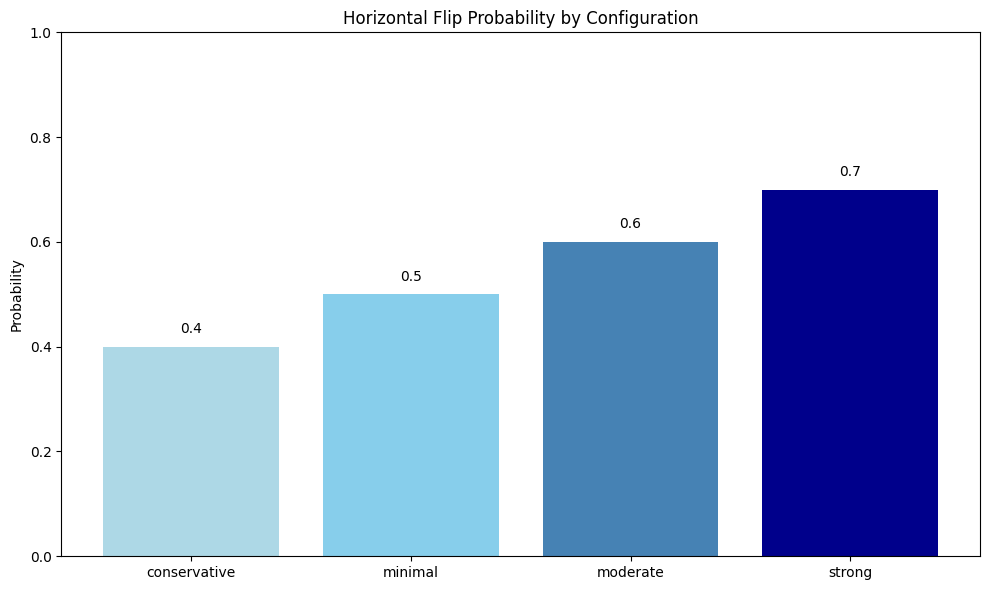


2. Color Jitter Intensity Analysis (Unified Paired Format):


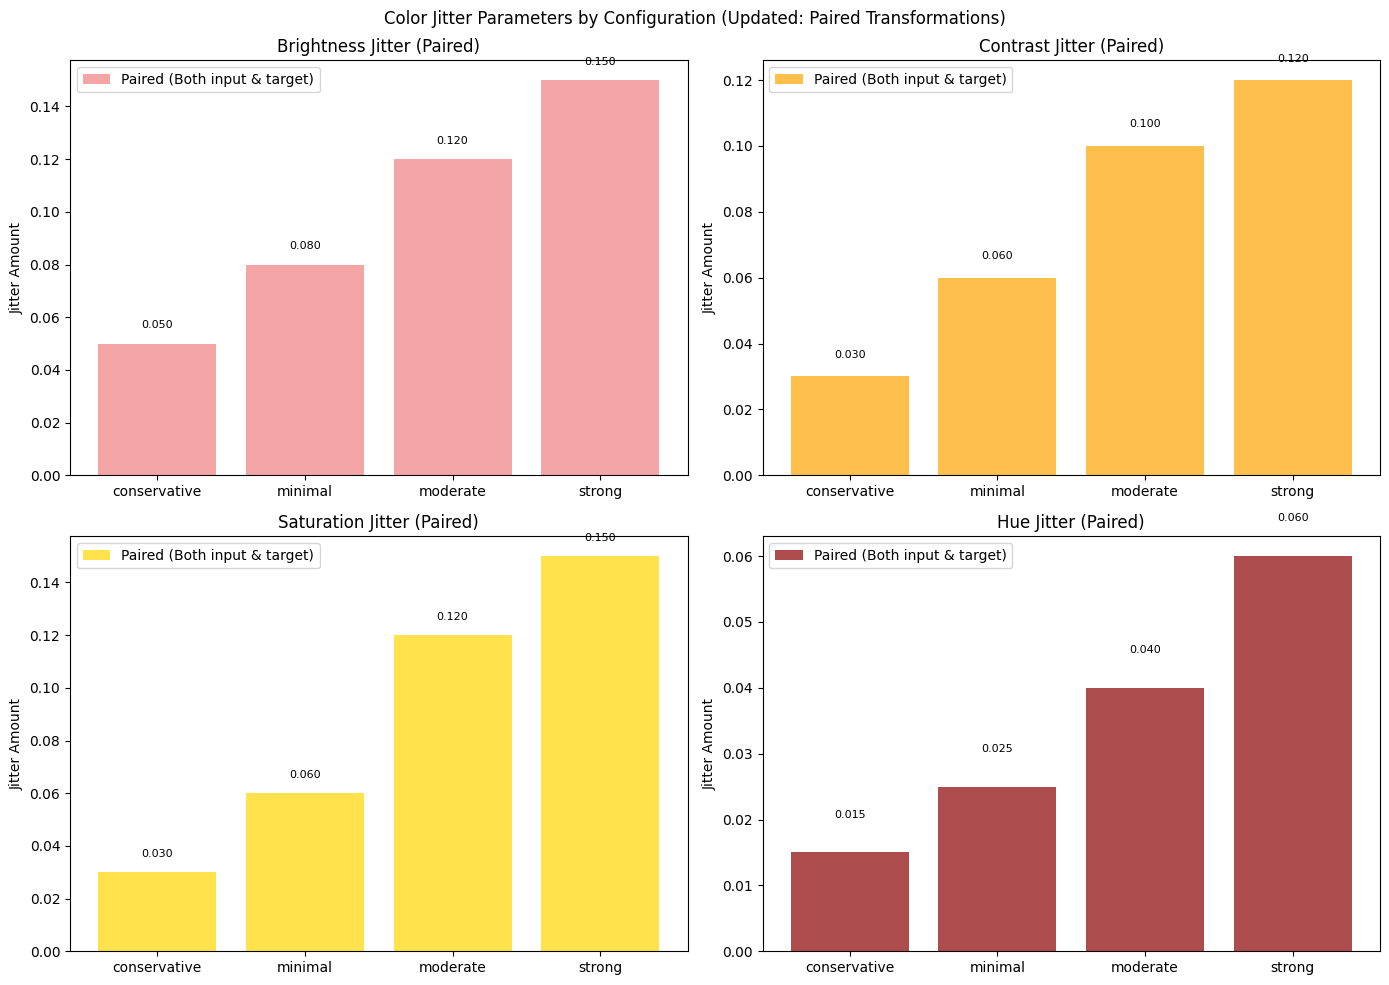


3. Cutout Configuration Analysis:


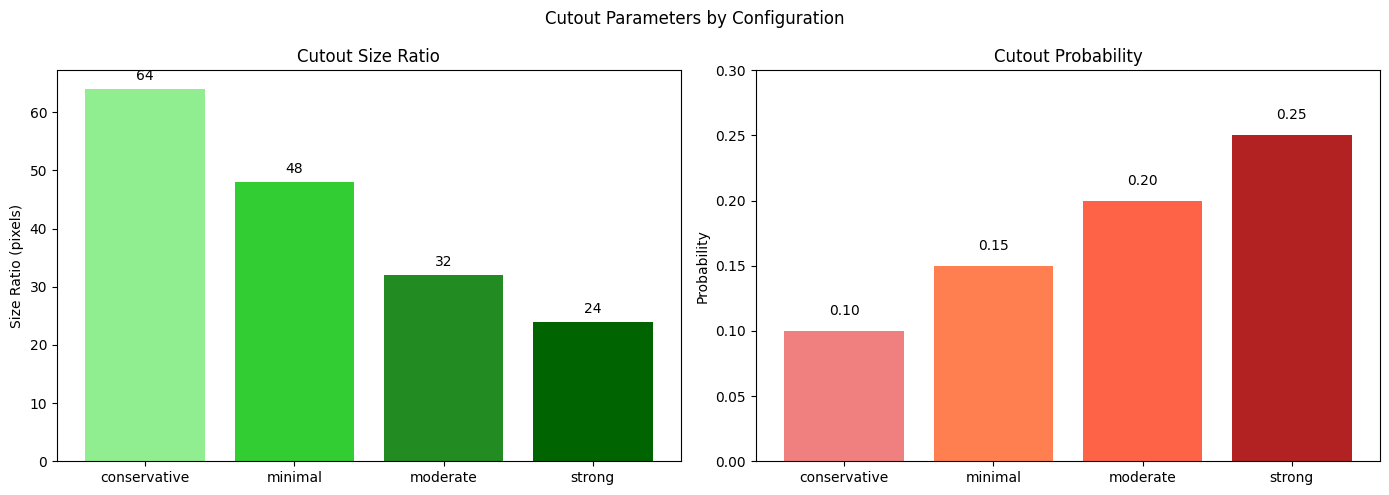


4. Configuration Summary (Updated for Paired Augmentations):
Configuration Flip Probability  Rotation (degrees) Avg Color Jitter Random Affine Prob  Cutout Size Ratio Cutout Probability Overall Intensity
 Conservative              0.4                   3            0.031               0.20                 64               0.10               Low
      Minimal              0.5                   4            0.056               0.25                 48               0.15            Medium
     Moderate              0.6                   5            0.095               0.30                 32               0.20            Medium
       Strong              0.7                   8            0.120               0.40                 24               0.25              High

5. Configuration Radar Chart (Updated for Paired Augmentations):
Configuration Flip Probability  Rotation (degrees) Avg Color Jitter Random Affine Prob  Cutout Size Ratio Cutout Probability Overall Intensity
 Conservative 

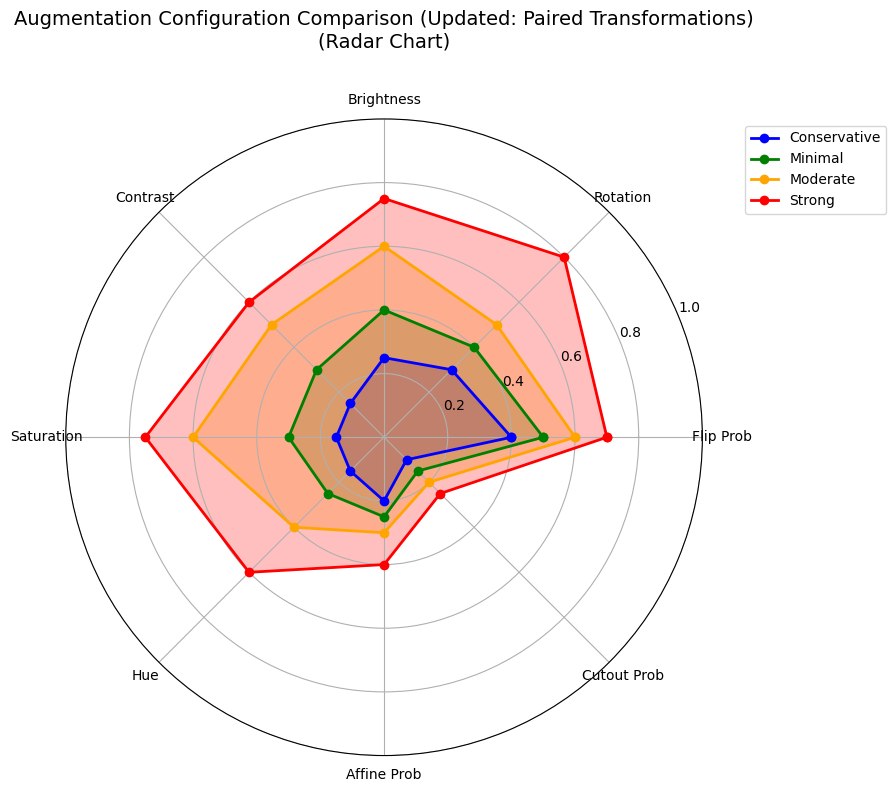


Configuration Analysis Complete!
Available configurations: conservative, minimal, moderate, strong
Currently using: moderate
Note: All augmentations now use paired transformations for better pixel art generation


In [12]:
# Augmentation Configuration Analysis
print("\n" + "="*60)
print("AUGMENTATION CONFIGURATION ANALYSIS")
print("="*60)

# Extract all augmentation configurations
config_names = ["conservative", "minimal", "moderate", "strong"]
configs = {name: project_config["augmentation_configs"][name] for name in config_names}

# 1. Horizontal Flip Probability Chart
print("\n1. Horizontal Flip Probability by Configuration:")
flip_probs = [configs[name]["horizontal_flip_p"] for name in config_names]

plt.figure(figsize=(10, 6))
bars = plt.bar(config_names, flip_probs, color=['lightblue', 'skyblue', 'steelblue', 'darkblue'])
plt.title('Horizontal Flip Probability by Configuration')
plt.ylabel('Probability')
plt.ylim(0, 1.0)

# Add value labels on bars
for bar, prob in zip(bars, flip_probs):
    plt.text(bar.get_x() + bar.get_width()/2., bar.get_height() + 0.02, 
             f'{prob:.1f}', ha='center', va='bottom')

plt.tight_layout()
plt.show()

# 2. Color Jitter Analysis (Updated for unified format)
print("\n2. Color Jitter Intensity Analysis (Unified Paired Format):")
color_params = ['brightness', 'contrast', 'saturation', 'hue']
config_colors = ['lightcoral', 'orange', 'gold', 'darkred']

fig, axes = plt.subplots(2, 2, figsize=(14, 10))
axes = axes.flatten()

for i, param in enumerate(color_params):
    # Updated to use unified color jitter format (no input/target separation)
    values = [configs[name]["color_jitter"][param] for name in config_names]
    
    x = np.arange(len(config_names))
    
    bars = axes[i].bar(x, values, label='Paired (Both input & target)', color=config_colors[i], alpha=0.7)
    
    axes[i].set_title(f'{param.title()} Jitter (Paired)')
    axes[i].set_ylabel('Jitter Amount')
    axes[i].set_xticks(x)
    axes[i].set_xticklabels(config_names)
    axes[i].legend()
    
    # Add value labels
    for j, val in enumerate(values):
        if val > 0:
            axes[i].text(j, val + 0.005, f'{val:.3f}', ha='center', va='bottom', fontsize=8)

plt.suptitle('Color Jitter Parameters by Configuration (Updated: Paired Transformations)')
plt.tight_layout()
plt.show()

# 3. Cutout Configuration Analysis
print("\n3. Cutout Configuration Analysis:")
cutout_size_ratios = [configs[name]["cutout"]["size_ratio"] for name in config_names]
cutout_probs = [configs[name]["cutout"]["p"] for name in config_names]

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

# Size ratios
bars1 = ax1.bar(config_names, cutout_size_ratios, color=['lightgreen', 'limegreen', 'forestgreen', 'darkgreen'])
ax1.set_title('Cutout Size Ratio')
ax1.set_ylabel('Size Ratio (pixels)')
for bar, ratio in zip(bars1, cutout_size_ratios):
    ax1.text(bar.get_x() + bar.get_width()/2., bar.get_height() + 1, 
             f'{ratio}', ha='center', va='bottom')

# Probabilities
bars2 = ax2.bar(config_names, cutout_probs, color=['lightcoral', 'coral', 'tomato', 'firebrick'])
ax2.set_title('Cutout Probability')
ax2.set_ylabel('Probability')
ax2.set_ylim(0, max(cutout_probs) * 1.2)
for bar, prob in zip(bars2, cutout_probs):
    ax2.text(bar.get_x() + bar.get_width()/2., bar.get_height() + 0.01, 
             f'{prob:.2f}', ha='center', va='bottom')

plt.suptitle('Cutout Parameters by Configuration')
plt.tight_layout()
plt.show()

# 4. Configuration Summary Table (Updated)
print("\n4. Configuration Summary (Updated for Paired Augmentations):")
import pandas as pd

summary_data = []
for name in config_names:
    config = configs[name]
    
    # Calculate average color jitter intensity (unified format)
    avg_color_jitter = np.mean([
        config["color_jitter"]["brightness"],
        config["color_jitter"]["contrast"],
        config["color_jitter"]["saturation"],
        config["color_jitter"]["hue"]
    ])
    
    summary_data.append({
        'Configuration': name.title(),
        'Flip Probability': f"{config['horizontal_flip_p']:.1f}",
        'Rotation (degrees)': config['rotation_degrees'],
        'Avg Color Jitter': f"{avg_color_jitter:.3f}",
        'Random Affine Prob': f"{config['random_affine']['p']:.2f}",
        'Cutout Size Ratio': config["cutout"]["size_ratio"],
        'Cutout Probability': f"{config['cutout']['p']:.2f}",
        'Overall Intensity': 'Low' if avg_color_jitter < 0.05 else 'Medium' if avg_color_jitter < 0.12 else 'High'
    })

summary_df = pd.DataFrame(summary_data)
print(summary_df.to_string(index=False))

# 5. Radar Chart for Configuration Comparison (Updated)
print("\n5. Configuration Radar Chart (Updated for Paired Augmentations):")
from math import pi

# Updated categories to reflect new augmentation structure
categories = ['Flip Prob', 'Rotation', 'Brightness', 'Contrast', 'Saturation', 'Hue', 'Affine Prob', 'Cutout Prob']

fig, ax = plt.subplots(figsize=(10, 8), subplot_kw=dict(projection='polar'))

angles = [n / float(len(categories)) * 2 * pi for n in range(len(categories))]
angles += angles[:1]  # Complete the circle

colors = ['blue', 'green', 'orange', 'red']

for i, config_name in enumerate(config_names):
    config = configs[config_name]
    
    values = [
        config["horizontal_flip_p"],
        config["rotation_degrees"] / 10.0,  # Scale for visibility
        config["color_jitter"]["brightness"] * 5,  # Scale for visibility
        config["color_jitter"]["contrast"] * 5,
        config["color_jitter"]["saturation"] * 5,
        config["color_jitter"]["hue"] * 10,  # Scale for visibility
        config["random_affine"]["p"],
        config["cutout"]["p"]
    ]
    values += values[:1]  # Complete the circle
    
    ax.plot(angles, values, 'o-', linewidth=2, label=config_name.title(), color=colors[i])
    ax.fill(angles, values, alpha=0.25, color=colors[i])

ax.set_xticks(angles[:-1])
ax.set_xticklabels(categories)
ax.set_ylim(0, 1)
ax.set_title('Augmentation Configuration Comparison (Updated: Paired Transformations)\n(Radar Chart)', size=14, y=1.1)
ax.legend(loc='upper right', bbox_to_anchor=(1.3, 1.0))

plt.tight_layout()
plt.show()

print(f"\nConfiguration Analysis Complete!")
print(f"Available configurations: {', '.join(config_names)}")
print(f"Currently using: {AUGMENTATION_CONFIG_TYPE}")
print(f"Note: All augmentations now use paired transformations for better pixel art generation")

In [13]:
# Data format analysis
if valid_pairs:
    sample_artwork, sample_sprite = valid_pairs[0]
    artwork_img = Image.open(sample_artwork)
    sprite_img = Image.open(sample_sprite)
    
    print("Data Format Analysis:")
    print(f"Artwork format: {artwork_img.mode} {artwork_img.size}")
    print(f"Sprite format: {sprite_img.mode} {sprite_img.size}")
    print(f"Artwork file size: {sample_artwork.stat().st_size:,} bytes")
    print(f"Sprite file size: {sample_sprite.stat().st_size:,} bytes")
else:
    print("No valid pairs found for format analysis")

Data Format Analysis:
Artwork format: RGBA (475, 475)
Sprite format: P (96, 96)
Artwork file size: 132,201 bytes
Sprite file size: 607 bytes


/home/khalil/DNN_tmp/venv/lib/python3.10/site-packages/sklearn/base.py:1365: ConvergenceWarning: Number of distinct clusters (14) found smaller than n_clusters (63). Possibly due to duplicate points in X.
  return fit_method(estimator, *args, **kwargs)


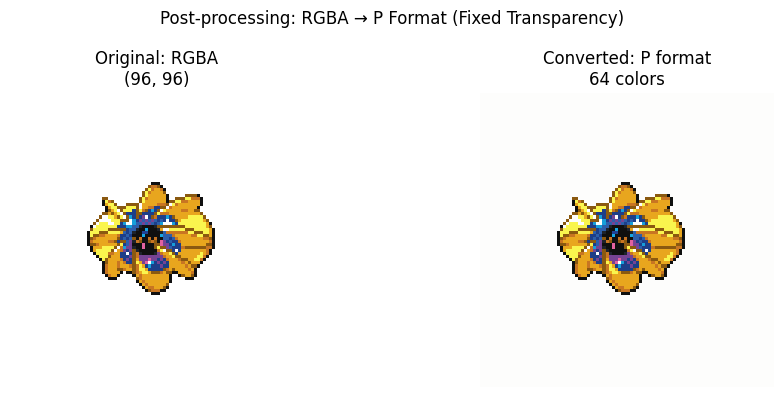

Post-processing Analysis:
Original size: 36,864 bytes
P format size: 9,984 bytes
Compression ratio: 3.69x
Size reduction: 72.9%
Palette colors: 14
Transparency preserved: Index 0

Pipeline test: SUCCESS


/home/khalil/DNN_tmp/venv/lib/python3.10/site-packages/sklearn/base.py:1365: ConvergenceWarning: Number of distinct clusters (14) found smaller than n_clusters (63). Possibly due to duplicate points in X.
  return fit_method(estimator, *args, **kwargs)


In [14]:
# Post-processing demonstration (reloaded)
import importlib
import data.postprocessing
importlib.reload(data.postprocessing)
from data.postprocessing import ARGBToPaletteConverter, SpritePostProcessor

if valid_pairs:
    # Initialize post-processor
    converter = ARGBToPaletteConverter(max_colors=64, preserve_transparency=True, optimize_palette=True)
    post_processor = SpritePostProcessor({'max_colors': 64, 'preserve_transparency': True, 'optimize_palette': True})
    
    # Test single image conversion
    sample_artwork, sample_sprite = valid_pairs[0]
    sprite_rgba = Image.open(sample_sprite).convert('RGBA')
    
    # Convert to P format
    p_sprite, palette = converter.convert_single_image(sprite_rgba)
    compression_analysis = converter.analyze_compression(sprite_rgba, p_sprite)
    
    # Visualization
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 4))
    
    ax1.imshow(sprite_rgba)
    ax1.set_title(f'Original: RGBA\n{sprite_rgba.size}')
    ax1.axis('off')
    
    # Convert P back to RGBA for proper transparency display
    p_sprite_rgba = converter.p_to_rgba_for_display(p_sprite)
    ax2.imshow(p_sprite_rgba)
    ax2.set_title(f'Converted: P format\n{len(palette)} colors')
    ax2.axis('off')
    
    plt.suptitle('Post-processing: RGBA → P Format (Fixed Transparency)')
    plt.tight_layout()
    plt.show()
    
    # Analysis results
    print("Post-processing Analysis:")
    print(f"Original size: {compression_analysis['rgba_size_bytes']:,} bytes")
    print(f"P format size: {compression_analysis['p_size_bytes']:,} bytes")
    print(f"Compression ratio: {compression_analysis['compression_ratio']:.2f}x")
    print(f"Size reduction: {compression_analysis['size_reduction_percent']:.1f}%")
    print(f"Palette colors: {compression_analysis['palette_colors']}")
    
    # Transparency verification
    if 'transparency' in p_sprite.info:
        print(f"Transparency preserved: Index {p_sprite.info['transparency']}")
    else:
        print("No transparency information found")
    
    # Test complete pipeline
    pipeline_result = post_processor.process_single_sprite(sprite_rgba, return_formats=['rgba', 'p'])
    print(f"\nPipeline test: {'SUCCESS' if 'p' in pipeline_result else 'FAILED'}")
    
else:
    print("No samples available for post-processing test")

/home/khalil/DNN_tmp/venv/lib/python3.10/site-packages/sklearn/base.py:1365: ConvergenceWarning: Number of distinct clusters (39) found smaller than n_clusters (63). Possibly due to duplicate points in X.
  return fit_method(estimator, *args, **kwargs)


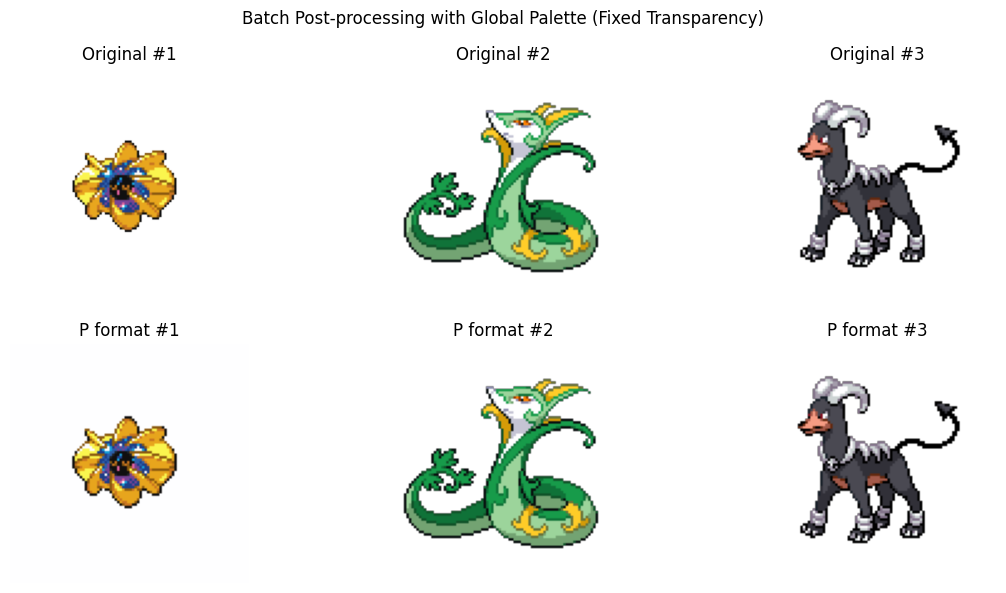

Batch Processing Analysis:
Batch size: 3
Global palette colors: 64
Sprites with transparency: 3/3
Sample compression: 3.69x reduction
Sample palette colors: 15


/home/khalil/DNN_tmp/venv/lib/python3.10/site-packages/sklearn/base.py:1365: ConvergenceWarning: Number of distinct clusters (39) found smaller than n_clusters (63). Possibly due to duplicate points in X.
  return fit_method(estimator, *args, **kwargs)


In [15]:
# Batch post-processing demonstration (fixed transparency)
if len(valid_pairs) >= 3:
    # Test batch processing with multiple sprites
    batch_sprites = []
    for i in range(3):
        sprite_path = valid_pairs[i][1]  # sprite path
        sprite_rgba = Image.open(sprite_path).convert('RGBA')
        batch_sprites.append(sprite_rgba)
    
    # Process batch with global palette
    p_sprites, global_palette = converter.convert_batch(batch_sprites, use_global_palette=True)
    
    # Visualization
    fig, axes = plt.subplots(2, 3, figsize=(12, 6))
    
    for i in range(3):
        # Original RGBA
        axes[0, i].imshow(batch_sprites[i])
        axes[0, i].set_title(f'Original #{i+1}')
        axes[0, i].axis('off')
        
        # Converted P format with proper transparency
        p_rgba = converter.p_to_rgba_for_display(p_sprites[i])
        axes[1, i].imshow(p_rgba)
        axes[1, i].set_title(f'P format #{i+1}')
        axes[1, i].axis('off')
    
    plt.suptitle('Batch Post-processing with Global Palette (Fixed Transparency)')
    plt.tight_layout()
    plt.show()
    
    # Batch analysis
    batch_result = post_processor.process_sprite_batch(batch_sprites, return_formats=['rgba', 'p'])
    print("Batch Processing Analysis:")
    print(f"Batch size: {batch_result['batch_size']}")
    print(f"Global palette colors: {len(batch_result['global_palette']) if batch_result['global_palette'] is not None else 'None'}")
    
    # Check transparency in all P format sprites
    transparency_count = sum(1 for p_sprite in p_sprites if 'transparency' in p_sprite.info)
    print(f"Sprites with transparency: {transparency_count}/{len(p_sprites)}")
    
    if 'sample_compression_analysis' in batch_result:
        analysis = batch_result['sample_compression_analysis']
        print(f"Sample compression: {analysis['compression_ratio']:.2f}x reduction")
        print(f"Sample palette colors: {analysis['palette_colors']}")
    
else:
    print("Not enough sprite pairs for batch processing demonstration")